In [ ]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import torch
from torch.autograd import Variable

# 做一些假数据来观看图像
x = torch.linspace(-5, 5, 200)  # x data (tensor), shape=(100, 1)
x = Variable(x)

x_np = x.data.numpy()   # 换成 numpy array, 出图时用

# 几种常用的 激励函数
y_relu = F.relu(x).data.numpy()
y_sigmoid = F.sigmoid(x).data.numpy()
y_tanh = F.tanh(x).data.numpy()
y_softplus = F.softplus(x).data.numpy()



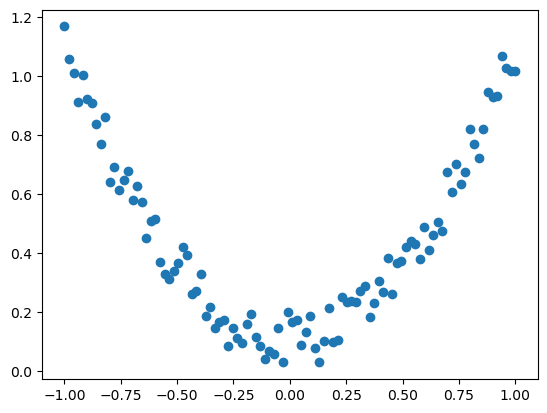

In [2]:
import torch
import matplotlib.pyplot as plt

x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# 画图
plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [1]:
import torch
import torch.nn.functional as F     # 激励函数都在这

class Net(torch.nn.Module):  # 继承 torch 的 Module
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()     # 继承 __init__ 功能
        # 定义每层用什么样的形式
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # 隐藏层线性输出
        self.predict = torch.nn.Linear(n_hidden, n_output)   # 输出层线性输出

    def forward(self, x):   # 这同时也是 Module 中的 forward 功能
        # 正向传播输入值, 神经网络分析出输出值
        x = F.relu(self.hidden(x))      # 激励函数(隐藏层的线性值)
        x = self.predict(x)             # 输出值
        return x

net = Net(n_feature=1, n_hidden=10, n_output=1)

print(net)  # net 的结构

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
# optimizer 是训练的工具
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)  # 传入 net 的所有参数, 学习率
loss_func = torch.nn.MSELoss()      # 预测值和真实值的误差计算公式 (均方差)

for t in range(100):
    prediction = net(x)     # 喂给 net 训练数据 x, 输出预测值

    loss = loss_func(prediction, y)     # 计算两者的误差

    optimizer.zero_grad()   # 清空上一步的残余更新参数值
    loss.backward()         # 误差反向传播, 计算参数更新值
    optimizer.step()        # 将参数更新值施加到 net 的 parameters 上

## 保存网络

In [ ]:
torch.save(net, 'net.pkl')  # 保存整个网络
torch.save(net.state_dict(), 'net_params.pkl')   # 只保存网络中的参数 (速度快, 占内存少)


## 提取网络

In [ ]:
def restore_net():
    # restore entire net1 to net2
    net2 = torch.load('net.pkl')
    prediction = net2(x)

## 只提取网络参数

In [ ]:
def restore_params():
    # 新建 net3
    net3 = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 1)
    )

    # 将保存的参数复制到 net3
    net3.load_state_dict(torch.load('net_params.pkl'))
    prediction = net3(x)

## Dataloader

In [ ]:
import torch
import torch.utils.data as Data
torch.manual_seed(1)    # reproducible

BATCH_SIZE = 5      # 批训练的数据个数

x = torch.linspace(1, 10, 10)       # x data (torch tensor)
y = torch.linspace(10, 1, 10)       # y data (torch tensor)

# 先转换成 torch 能识别的 Dataset
torch_dataset = Data.TensorDataset(data_tensor=x, target_tensor=y)

# 把 dataset 放入 DataLoader
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)

for epoch in range(3):   # 训练所有!整套!数据 3 次
    for step, (batch_x, batch_y) in enumerate(loader):  # 每一步 loader 释放一小批数据用来学习
        # 假设这里就是你训练的地方...

        # 打出来一些数据
        print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
              batch_x.numpy(), '| batch y: ', batch_y.numpy())

"""
Epoch:  0 | Step:  0 | batch x:  [ 6.  7.  2.  3.  1.] | batch y:  [  5.   4.   9.   8.  10.]
Epoch:  0 | Step:  1 | batch x:  [  9.  10.   4.   8.   5.] | batch y:  [ 2.  1.  7.  3.  6.]
Epoch:  1 | Step:  0 | batch x:  [  3.   4.   2.   9.  10.] | batch y:  [ 8.  7.  9.  2.  1.]
Epoch:  1 | Step:  1 | batch x:  [ 1.  7.  8.  5.  6.] | batch y:  [ 10.   4.   3.   6.   5.]
Epoch:  2 | Step:  0 | batch x:  [ 3.  9.  2.  6.  7.] | batch y:  [ 8.  2.  9.  5.  4.]
Epoch:  2 | Step:  1 | batch x:  [ 10.   4.   8.   1.   5.] | batch y:  [  1.   7.   3.  10.   6.]
可以看出, 每步都导出了5个数据进行学习. 然后每个 epoch 的导出数据都是先打乱了以后再导出.
"""

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # 数据库模块
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 50
LR = 0.001          # 学习率
DOWNLOAD_MNIST = False  # 如果你已经下载好了mnist数据就写上 False


# Mnist 手写数字
train_data = torchvision.datasets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(),    # 转换 PIL.Image or numpy.ndarray 成
                                                    # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=DOWNLOAD_MNIST,          # 没下载就下载, 下载了就不用再下了
)

100.0%


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100.0%


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100.0%


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100.0%

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [3]:
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)

# 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# 为了节约时间, 我们测试时只测试前2000个
test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.targets[:2000]



In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,      # input height
                out_channels=16,    # n_filters
                kernel_size=5,      # filter size
                stride=1,           # filter movement/step
                padding=2,      # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1
            ),      # output shape (16, 28, 28)
            nn.ReLU(),    # activation
            nn.MaxPool2d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图成 (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [5]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # 分配 batch data, normalize x when iterate train_loader
        output = cnn(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

"""
...
Epoch:  0 | train loss: 0.0306 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0147 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0427 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0078 | test accuracy: 0.98
"""

'\n...\nEpoch:  0 | train loss: 0.0306 | test accuracy: 0.97\nEpoch:  0 | train loss: 0.0147 | test accuracy: 0.98\nEpoch:  0 | train loss: 0.0427 | test accuracy: 0.98\nEpoch:  0 | train loss: 0.0078 | test accuracy: 0.98\n'

In [6]:
test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

"""
[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
"""

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


'\n[7 2 1 0 4 1 4 9 5 9] prediction number\n[7 2 1 0 4 1 4 9 5 9] real number\n'